# Wetland water depth visualisation <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` and `DEA Sandbox` environment 
* **Products used:** 
* **Special requirements:** 
* **Prerequisites:** This notebook assumes you have previously run the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook and saved out a netCDF file containing all the variables at the end of the notebook.

## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic

sys.path.append('../../Scripts')
from dea_spatialtools import subpixel_contours

%load_ext autoreload
%autoreload 2

### Analysis parameters

* `AnalysisLocation`: A string descriptor of the analysis region used to label graphs.

#### Files to analyse
* `DatasetToLoad` : The filename of the netCDF written out by the [first notebook](./WetlandWaterDepthAnalyses.ipynb) to read in here. Note that this file must have been written out by the first notebook, as we assume the variables created in that notebook exist here. If you try to read in something else, this code will fail.
* `SpeciesDictToLoad` : The filename of the text file written out by the [first notebook](./WetlandWaterDepthAnalyses.ipynb) that contains the species dictionary of vegetation type and numerical ID. This is used to label plots.

#### Analysis options
* `Decades` : e.g. `{'1990s':('1990-01-01', '1999-12-31'), '2000s':('2000-01-01', '2009-12-31'), '2010s':('2010-01-01', '2019-12-31')}`. A dictionary of decades over which to analyse some of our results. If you want this to be a different time period other than decades, just change that here and include an appropriate descriptive dictionary key for each time period. 
* `PercentilesToCalc`: e.g. `['1', '25', '50', '75', '99']`. In the code below we do some analysis using percentiles. Include the percentiles you want to calculate as a list of strings here. We turn them into integers below to do the calculation, but use these strings for labelling.

In [2]:
AnalysisLocation = 'Narran Lakes'

DatasetToLoad = 'AllDataCombinedBigNarranLakes.nc'
SpeciesDictToLoad = 'SpeciesDictBigNarranLakes.txt'

Decades = {'1990s':('1990-01-01', '1999-12-31'), '2000s':('2000-01-01', '2009-12-31'), '2010s':('2010-01-01', '2019-12-31')}
PercentilesToCalc = ['1', '5', '10', '25', '50', '75', '99']

## Load in our pre-analysed datasets

In [3]:
AllDataCombined = xr.open_dataset(DatasetToLoad)

We also need to load in the species dictionary we saved out

In [4]:
with open(SpeciesDictToLoad, 'r') as f: 
    content = f.read()
    SpeciesDict = eval(content)

We need to regenerate the order of vegetation communities by mean HAND, and then match up that order with the `SpeciesDict` to get the tick labels.

In [5]:
# Now recalculate our median HAND values and sort the data based on this
MedianHAND = AllDataCombined.HAND.groupby(AllDataCombined['veg_randomUID']).median()
myorder = MedianHAND.sortby(MedianHAND)['veg_randomUID'].values

In [6]:
# Grab the correct vegetation labels in the right order
XTickNames = []
for vegvalue in myorder:
    VegName = SpeciesDict[int(vegvalue)]
    XTickNames.append(VegName)

## Apply pixel contouring to HAND

In [22]:
# Extract waterline contours for the supplied water index threshold:
contour_gdf = subpixel_contours(da=AllDataCombined.HAND,                               
                                z_values= np.arange(start=AllDataCombined.HAND.min(), stop=AllDataCombined.HAND.max(), step=0.5),
                                crs=AllDataCombined.attrs['crs'])

Operating in multiple z-value, single array mode


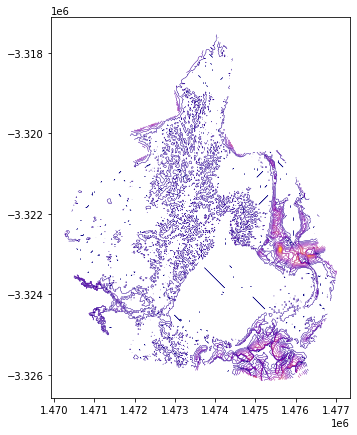

In [23]:
contour_gdf.plot(figsize=(12, 7), cmap = 'plasma', linewidth=0.5);
#AllDataCombined['wetFreq'].plot(cmap='cubehelix_r');

## What vegetation communities have been observed as wet in a single scene?

This code plots the mapped vegetation communities within our region of interest by the HAND heights taken from *just wet* pixels. It plots this as a violin plot for a single timestep. 

This visualisation is a useful snapshot of vegetation inundation at a single point in time.

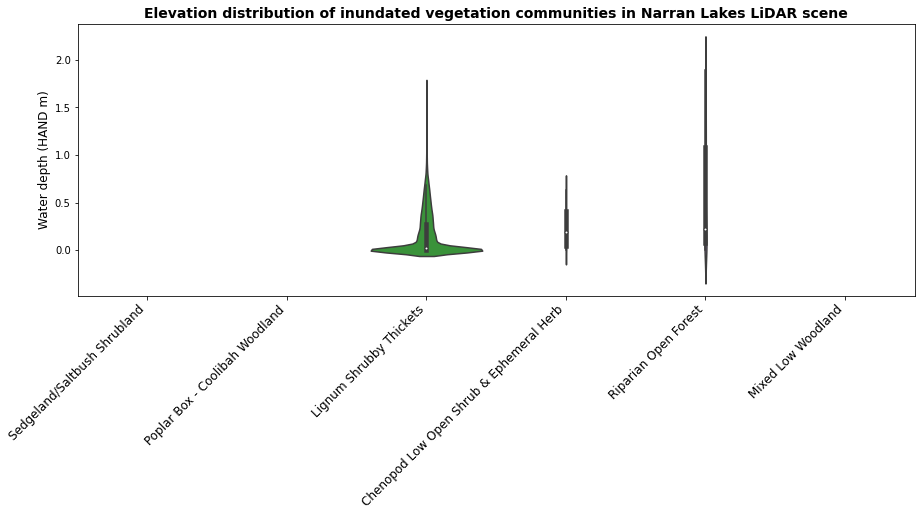

In [7]:
fig = plt.figure(figsize=[15,5])
ax = sns.violinplot(x=AllDataCombined['veg_randomUID'].values.flatten(), 
                    y=AllDataCombined['justwetHAND'].isel(time=30).values.flatten(), 
                    order=myorder, scale='count')
ax.set_xticklabels(XTickNames, rotation=45, ha='right', fontsize=12);
plt.ylabel('Water depth (HAND m)', fontsize = 12);
plt.title(f'Elevation distribution of inundated vegetation communities in {AnalysisLocation} LiDAR scene', 
          fontsize = 14, fontweight = 'bold');

## Count up the frequency of wet observations per pixel

In [8]:
AllDataCombined['wetFreq'] = AllDataCombined['wetCount'].sum(dim=['time'])
AllDataCombined['wetFreq'] = AllDataCombined['wetFreq'].where(AllDataCombined['wetFreq'] != 0)

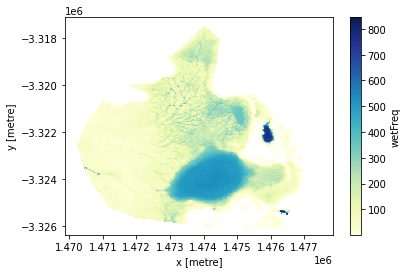

In [9]:
AllDataCombined['wetFreq'].plot(cmap='YlGnBu');

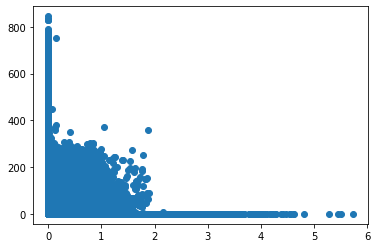

In [10]:
plt.scatter(AllDataCombined['HAND'], AllDataCombined['wetFreq']);

### Count the number of wet observations for each pixel, and plot against HAND

We would hope that the higher pixels are inundated less frequently...

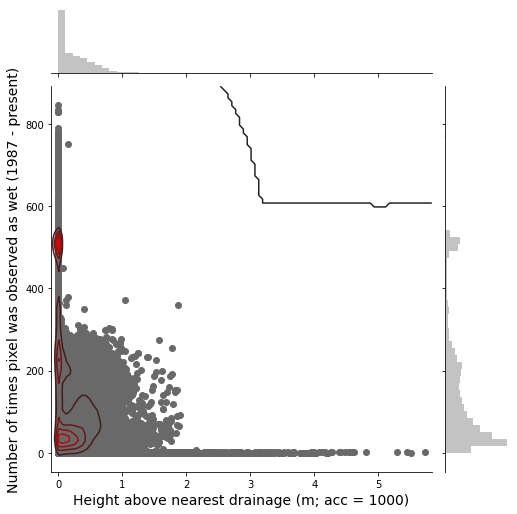

In [11]:
h = (sns.jointplot(x=AllDataCombined.HAND.values.flatten(), 
                   y=AllDataCombined.wetFreq.values.flatten(), 
                   kind='scatter', height=7,color='dimgrey').plot_joint(sns.kdeplot, 
                                                         zorder=1,
                                                         n_levels=5, color='r'));
h.set_axis_labels(f'Height above nearest drainage (m; acc = 1000)', 
                  'Number of times pixel was observed as wet (1987 - present)', fontsize=14);

## Calculate wet count per scene curves

Count up the number of wet pixels in each timestep

In [12]:
WetCountPerTime = AllDataCombined.wetCount.sum(dim=['x', 'y'])
# Remove any observations where everything is dry
WetCountPerTime = WetCountPerTime[WetCountPerTime != 0]

In [13]:
AllDataCombined['WetCounts'] = WetCountPerTime

Sort this from highest to lowest, and assign a cumulative percent axis to plot against

In [14]:
# Sort highest to lowest
WetCountPerTimeSorted = -np.sort(-WetCountPerTime.values)
# Create an array the length of the total number of observations
CumulativePct = np.array(range(len(WetCountPerTime.values)))
# Turn that array into a percent
CumulativePct = (CumulativePct / len(CumulativePct)) * 100

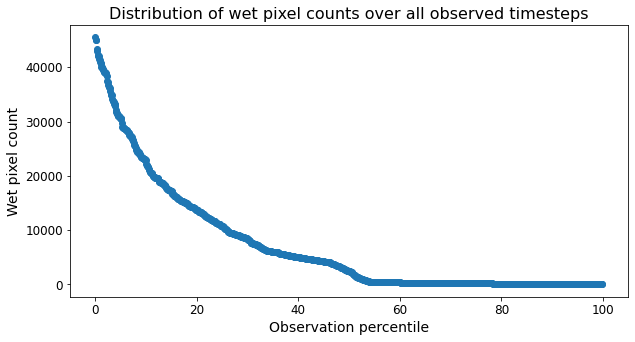

In [15]:
fig, ax = plt.subplots(figsize=[10,5]);
plt.plot(CumulativePct, WetCountPerTimeSorted, 'o');
ax.tick_params(axis = 'both', labelsize = 12)
plt.xlabel('Observation percentile', fontsize=14);
plt.ylabel('Wet pixel count', fontsize=14);
plt.title('Distribution of wet pixel counts over all observed timesteps', fontsize=16);

### Create the same curves by decade

In [16]:
DecadeData = {}
for name, decade in Decades.items():
    WetCount = WetCountPerTime.sel({'time': slice(*decade)})
    SortedCount = -np.sort(-WetCount.values)
    CumPct = np.array(range(len(SortedCount)))
    CumPct = (CumPct / len(CumPct)) * 100
    DecadeData.update({name: list(zip(CumPct, SortedCount))})

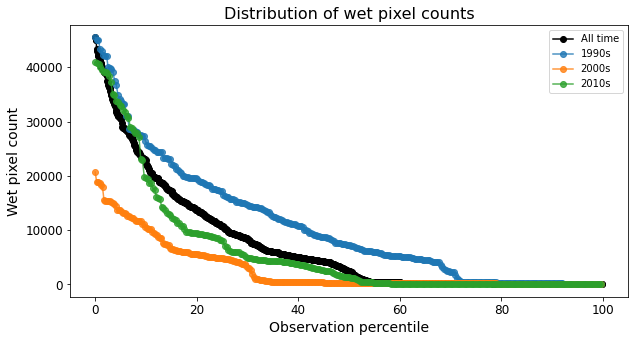

In [17]:
fig, ax = plt.subplots(figsize=[10,5]);
plt.plot(CumulativePct, WetCountPerTimeSorted, 'o-k', label='All time');
for names, data in DecadeData.items():
    CumPct, SortedCount = list(zip(*data))
    plt.plot(CumPct, SortedCount, 'o-', alpha=0.8, label=names);
# apply a symlog scale (symmetrical log) to highlight values near zero
#plt.xscale('symlog')
ax.tick_params(axis = 'both', labelsize = 12)
plt.legend()
plt.xlabel('Observation percentile', fontsize=14);
plt.ylabel('Wet pixel count', fontsize=14);
plt.title('Distribution of wet pixel counts', fontsize=16);

## Draw violin plots according to wet pixel count

Now that we have wet pixel counts for each scene, we can draw violin plots showing the inundation of vegetation types for different wetness counts

In [18]:
AllDataCombined['HANDclip'] = AllDataCombined['justwetHAND'].where(AllDataCombined['HAND']<=2)

In [19]:
WetCountPercentiles = np.percentile(WetCountPerTime.values, [int(x) for x in PercentilesToCalc], interpolation='nearest')

In [20]:
PercentilesLoop = dict(list(zip(PercentilesToCalc, WetCountPercentiles)))
PercentilesData = {}

for pctname, perctl in PercentilesLoop.items():
    FindTime = AllDataCombined.time.where(AllDataCombined['WetCounts'] == perctl, drop=True)
    PercentilesData.update({pctname: {'percentile': perctl, 'timestep':FindTime}})

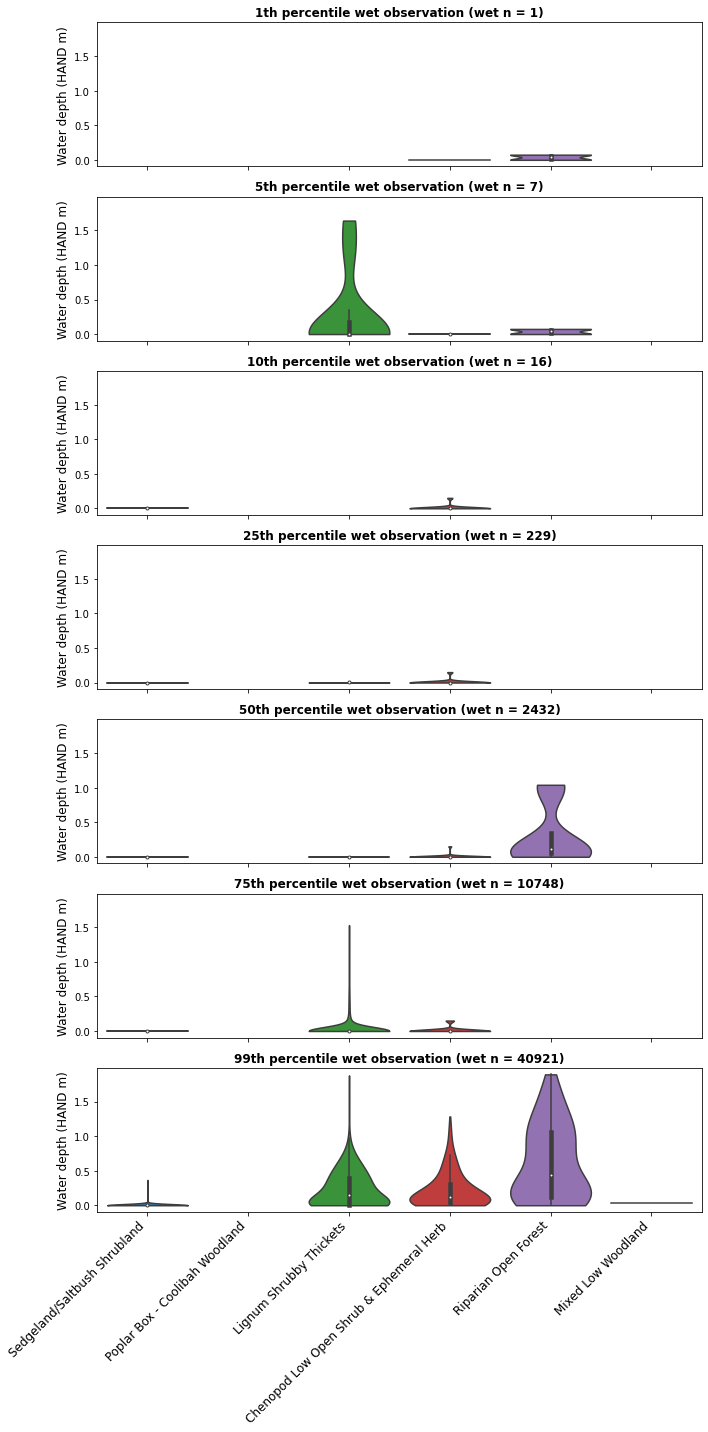

In [24]:
fig, axes = plt.subplots(len(PercentilesToCalc), 1, figsize=(10, 20), sharey=True);

for axesh, perctl in enumerate(PercentilesData.items()):
    if len(AllDataCombined['HANDclip'].sel(time=perctl[1]['timestep']).time) != 1:
        yvalues = AllDataCombined['HANDclip'].sel(time=perctl[1]['timestep']).max(dim='time')
    else:
        yvalues = AllDataCombined['HANDclip'].sel(time=perctl[1]['timestep'])
    ax = sns.violinplot(x=AllDataCombined['veg_randomUID'].values.flatten(), 
                        y=yvalues.values.flatten(), 
                        order=myorder, scale='width', cut=0, bw = 0.5, ax=axes[axesh])
    ax.set_xticklabels('');
    ax.set_ylabel('Water depth (HAND m)', fontsize = 12);
    ax.set_title(f'{perctl[0]}th percentile wet observation (wet n = {PercentilesLoop[perctl[0]]})', 
              fontsize = 12, fontweight = 'bold');
# axes[0].set_title('Elevation distribution of inundated vegetation communities for percentile wet observation', 
#               fontsize = 14, fontweight = 'bold');
axes[-1].set_xticklabels(XTickNames, rotation=45, ha='right', fontsize=12);
plt.tight_layout()
fig.savefig(f'Percentiles_{AnalysisLocation.replace(" ", "")}')

## Bin observations by percentile and plot frequency of inundation

Recalculate our percentiles, but this time we want every 10th percentile

In [78]:
WetCountRangePercentiles = np.percentile(WetCountPerTime.values, range(0,100,10), interpolation='nearest')

Grab the timesteps that fall between 0-10th, 10-20th etc percentiles. Data in `PercentileRangeData` are named for the bottom percentile, so `20` refers to the `20-30`th percentile bracket.

In [79]:
PercentileRangeData = {}
for ix, perctl in enumerate(zip([str(i) for i in range(0,110,10)], WetCountRangePercentiles)):
    try:
        FindTime = AllDataCombined.time.where(((AllDataCombined['WetCounts'] > WetCountRangePercentiles[ix]) & 
                                               (AllDataCombined['WetCounts'] <= WetCountRangePercentiles[ix + 1])), drop=True)
    except IndexError:
        FindTime = AllDataCombined.time.where(((AllDataCombined['WetCounts'] > WetCountRangePercentiles[ix])), drop=True)
    PercentileRangeData.update({perctl[0]: {'percentile': perctl[1], 'timestep':FindTime}})

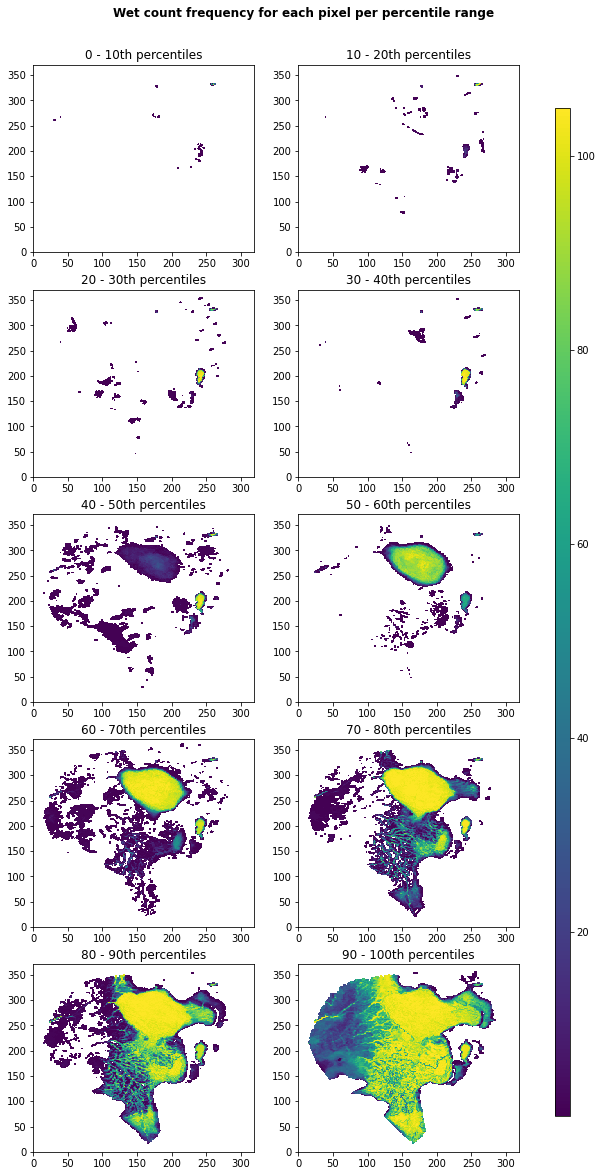

In [172]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20));

axes = axes.ravel()

for axesh, perctl in enumerate(PercentileRangeData.items()):
    ExtractedData = AllDataCombined['HANDclip'].sel(time=perctl[1]['timestep']).count(dim='time')
    ax = plt.subplot(5,2,axesh + 1)
    ax.set_title(f'{perctl[0]} - {int(perctl[0])+10}th percentiles')
    h = ax.pcolor(ExtractedData.where(ExtractedData != 0), cmap='viridis')

fig.subplots_adjust(right=0.8);
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]);
fig.colorbar(h, cax=cbar_ax);
fig.suptitle('Wet count frequency for each pixel per percentile range', y=0.92, fontweight='bold');

fig.savefig(f'Percentile_ranges_{AnalysisLocation.replace(" ", "")}')

### Can we do it by species?

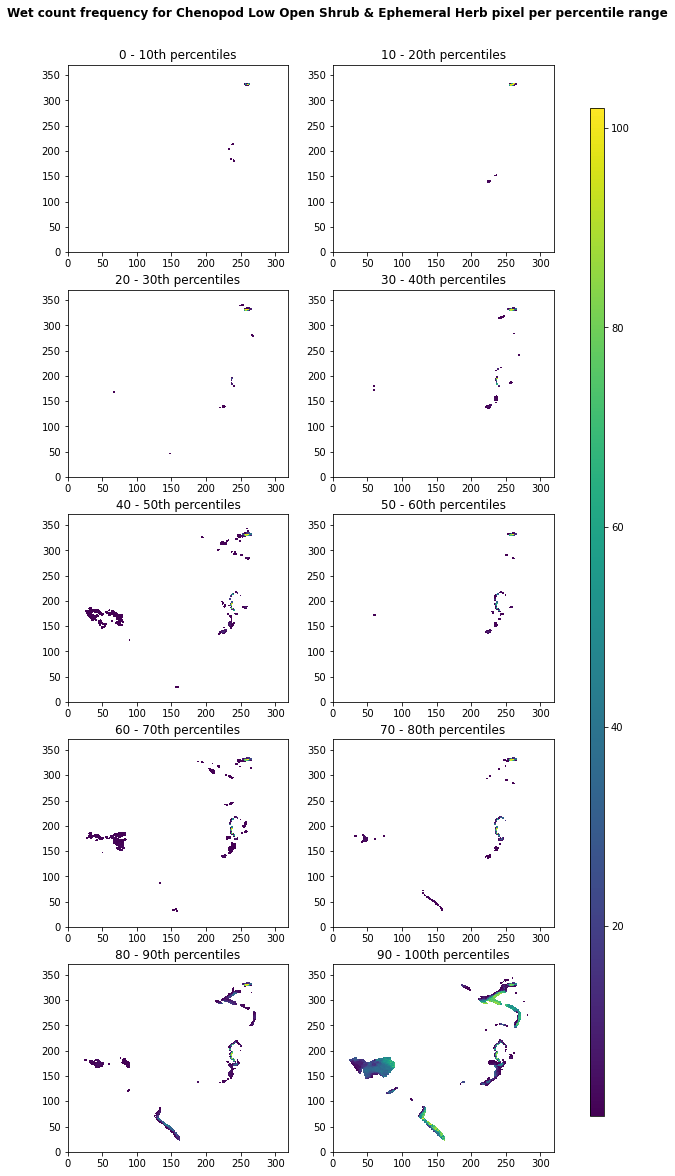

In [176]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20));
axes = axes.ravel()

PickASpeciesNum = 0

for axesh, perctl in enumerate(PercentileRangeData.items()):
    ExtractedData = AllDataCombined['HANDclip'].sel(time=perctl[1]['timestep']).count(dim='time')
    BySpecies = ExtractedData.where(AllDataCombined['veg_randomUID'] == PickASpeciesNum)
    ax = plt.subplot(5,2,axesh + 1)
    ax.set_title(f'{perctl[0]} - {int(perctl[0])+10}th percentiles')
    h = ax.pcolor(BySpecies.where(BySpecies != 0), cmap='viridis')

fig.subplots_adjust(right=0.8);
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]);
fig.colorbar(h, cax=cbar_ax);
fig.suptitle(f'Wet count frequency for {SpeciesDict[PickASpeciesNum]} pixel per percentile range', y=0.92, fontweight='bold');

fig.savefig(f'Percentile_ranges_{AnalysisLocation.replace(" ", "")}_{SpeciesDict[PickASpeciesNum].replace(" ", "")}')